In [8]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, K, N, P, NORMALIZE_FLAGS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


In [9]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.0105, 0.2601, 0.9207],
        [0.0848, 0.1133, 0.0725],
        [0.4631, 0.1014, 0.2942],
        [0.0046, 0.0921, 0.8747],
        [0.6639, 0.1840, 0.0930]])


In [10]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)


[   30    63    90 ... 99871 99921 99960]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


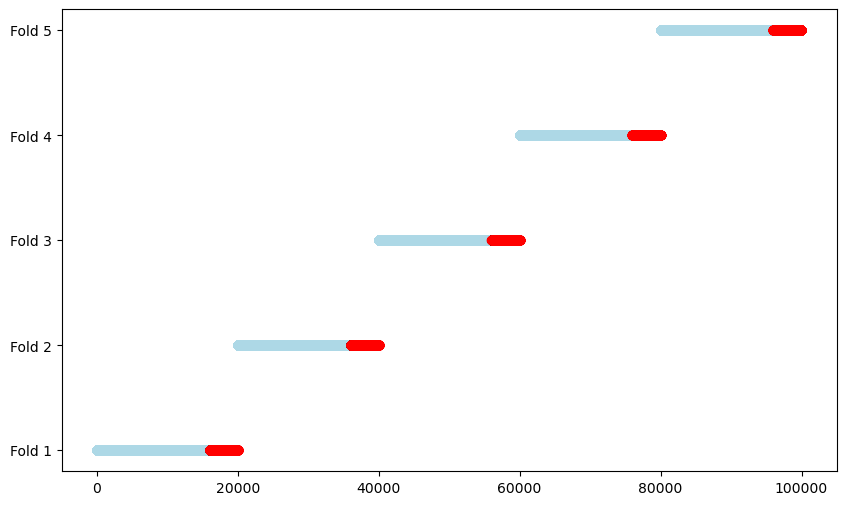

In [11]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [12]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19972, 100, 3])
X_mask shape: torch.Size([19972, 100])
X_indices shape: torch.Size([19972, 4, 1])
y shape: torch.Size([19972, 1])


Number of finished trials:  100
Best trial: 23
Best hyperparameters: {'learning_rate': 0.000975943388806886, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64}
Validation Losses: [35.351, 39.998, 46.143, 47.799, 38.72]
Mean validation loss: 41.602
Test Losses: [57.109, 49.14, 53.83, 47.486, 60.914]
Mean test loss: 53.696
Mean test MAE: 4.894 std: 0.212
Mean test RMSE: 7.32 std: 0.338


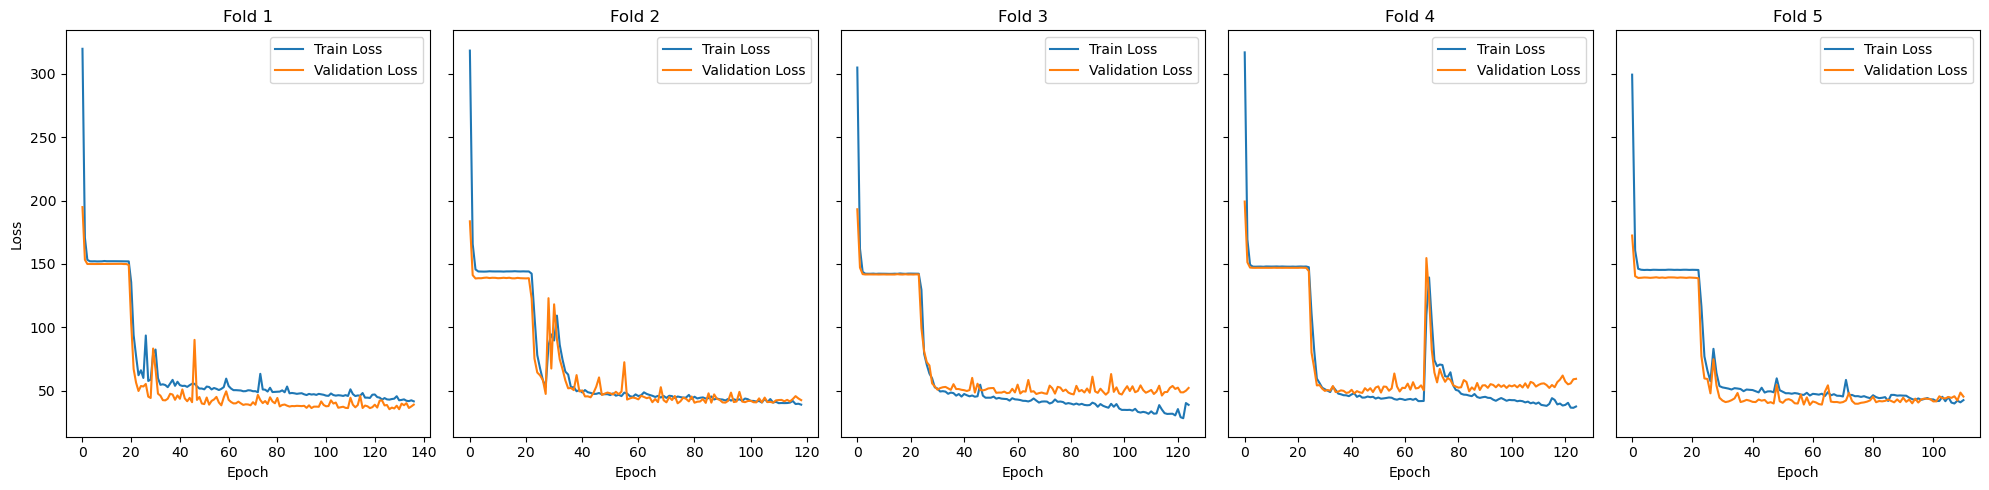

In [13]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series}
#run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


Best hyperparameters: {'learning_rate': 0.000975943388806886, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64}
Early stopping at epoch 137, with best epoch being 126
Early stopping at epoch 119, with best epoch being 74
Early stopping at epoch 125, with best epoch being 114
Early stopping at epoch 125, with best epoch being 41
Early stopping at epoch 111, with best epoch being 59
Validation Losses: [35.350738525390625, 39.997684478759766, 46.14311981201172, 47.799495697021484, 38.72002029418945]
Mean validation loss: 41.60221176147461
Test Losses: [57.10941696166992, 49.1395149230957, 53.83025360107422, 47.485713958740234, 60.91419219970703]
Mean test loss: 53.69581832885742


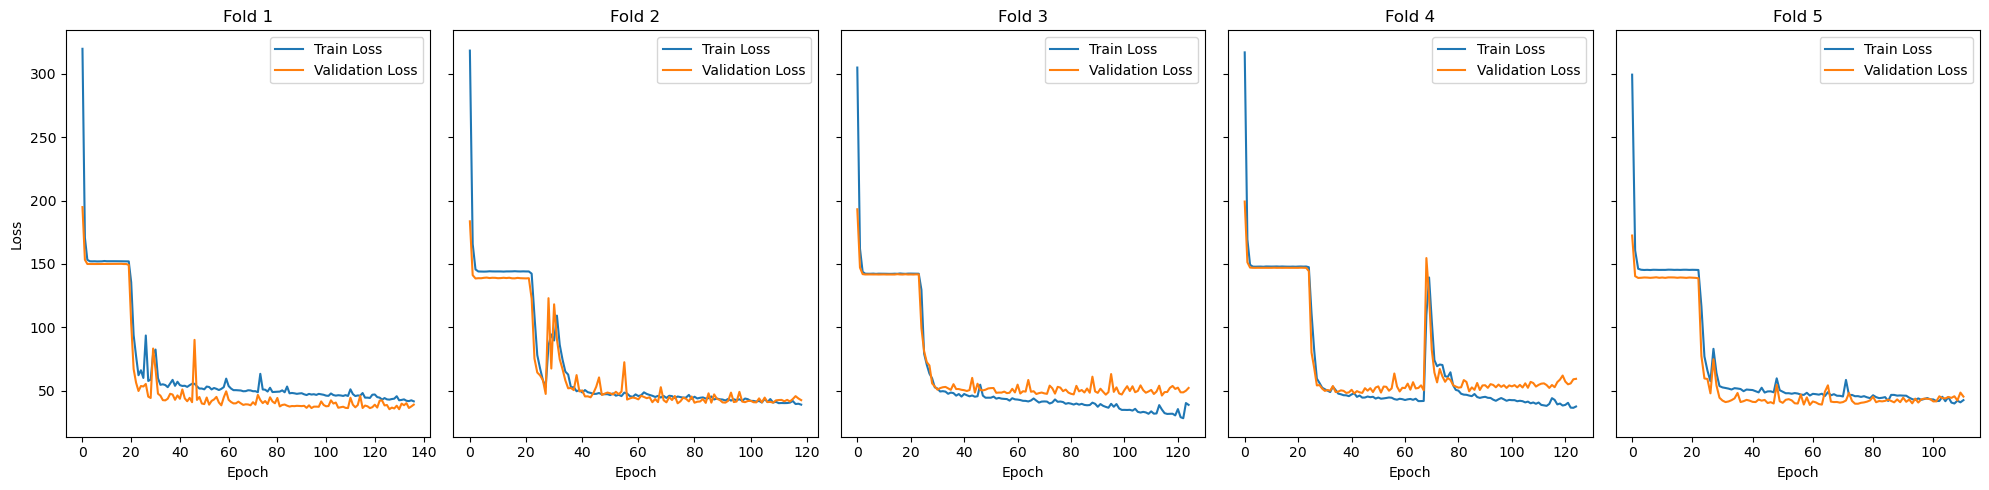

In [14]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 98
Best hyperparameters: {'learning_rate': 0.0008990626874073046, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 64}
Validation Losses: [38.568, 34.722, 47.318, 44.048, 35.04]
Mean validation loss: 39.939
Test Losses: [61.144, 50.775, 50.432, 43.253, 78.714]
Mean test loss: 56.864
Mean test MAE: 4.976 std: 0.387
Mean test RMSE: 7.499 std: 0.792


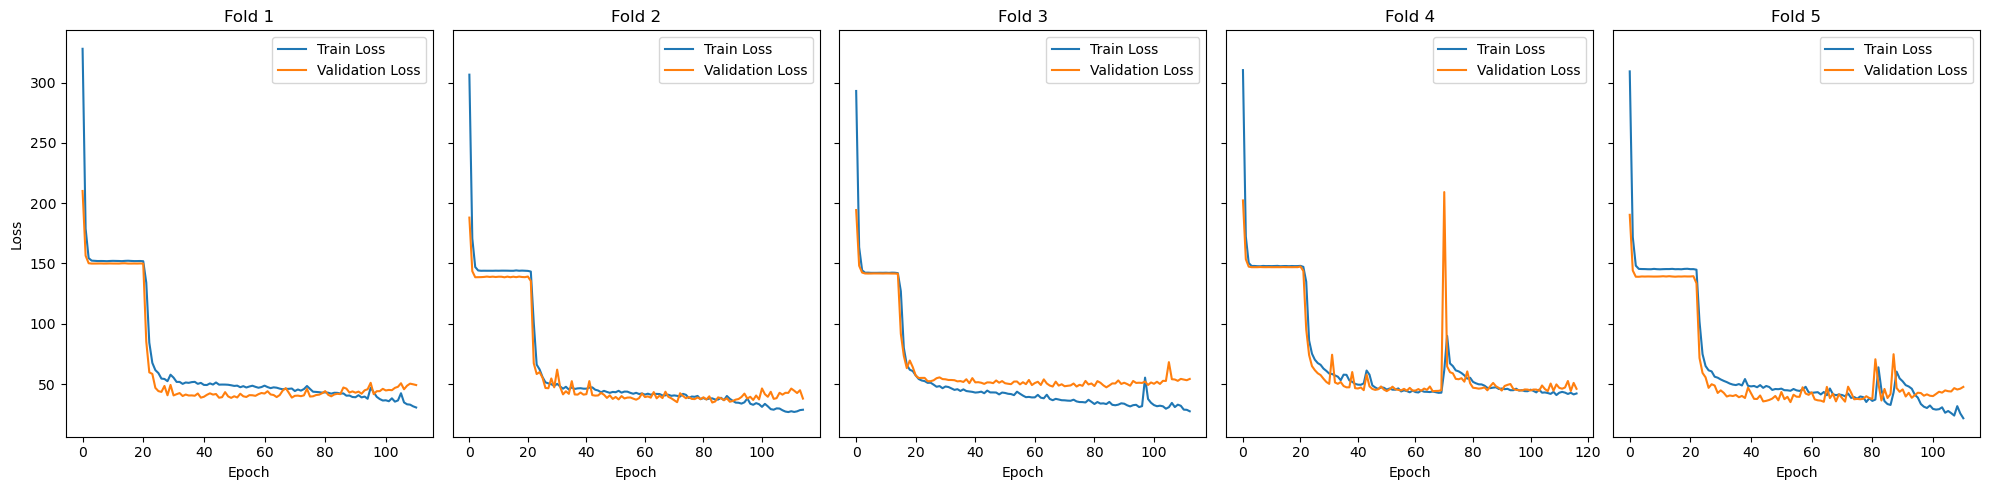

In [15]:
from models.lstm_pytorch import LSTM

n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)

X = {"X_series": X_series, "X_mask": X_mask}
#run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))



Best hyperparameters: {'learning_rate': 0.0008990626874073046, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 64}
Early stopping at epoch 111, with best epoch being 49
Early stopping at epoch 115, with best epoch being 83
Early stopping at epoch 113, with best epoch being 84
Early stopping at epoch 117, with best epoch being 66
Early stopping at epoch 111, with best epoch being 53
Validation Losses: [38.5679931640625, 34.72153091430664, 47.31824493408203, 44.047847747802734, 35.0401611328125]
Mean validation loss: 39.93915557861328
Test Losses: [61.14408874511719, 50.77543258666992, 50.431644439697266, 43.2532844543457, 78.7139663696289]
Mean test loss: 56.8636833190918


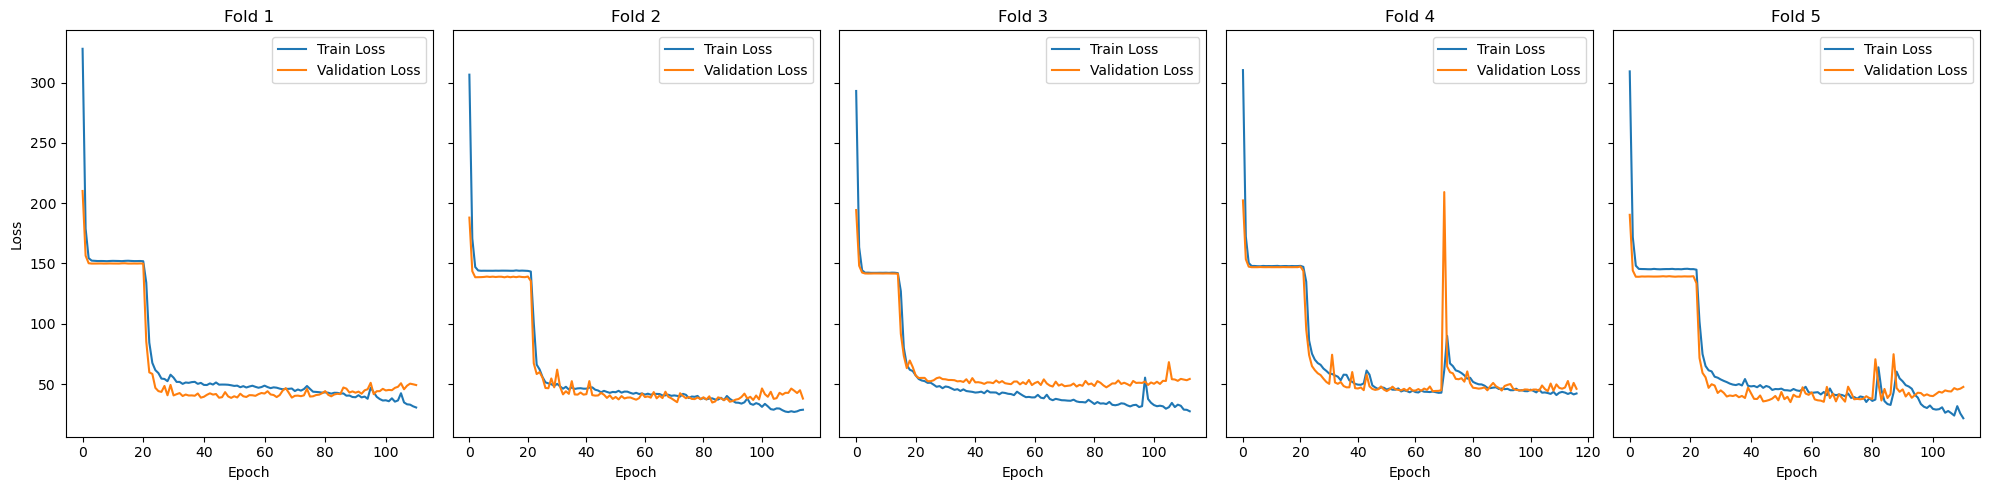

In [ ]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


In [21]:
from models.lstm_pytorch import LSTM
from utils.utils import print_study_results, plot_best_model_results


n_trials = 100
num_epochs = 500
model_type = "LSTM"
model_name = "LSTM_Indexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X_indices = {"X_indices": X_indices}
run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


[I 2025-01-04 17:44:48,993] A new study created in memory with name: no-name-8015241c-90ff-4072-9394-593420f8b071


Early stopping at epoch 366, with best epoch being 354
Early stopping at epoch 308, with best epoch being 297
Early stopping at epoch 449, with best epoch being 438
Early stopping at epoch 380, with best epoch being 369


[I 2025-01-04 17:52:56,979] Trial 0 finished with value: 143.18056030273436 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 32}. Best is trial 0 with value: 143.18056030273436.


Early stopping at epoch 313, with best epoch being 302
Early stopping at epoch 257, with best epoch being 246
Early stopping at epoch 213, with best epoch being 202
Training completed all epochs. Best epoch was 499
Training completed all epochs. Best epoch was 498


[I 2025-01-04 17:57:06,204] Trial 1 finished with value: 111.41848297119141 and parameters: {'learning_rate': 1.793578709982463e-05, 'num_layers': 1, 'batch_size': 128, 'hidden_size_layer_0': 256}. Best is trial 1 with value: 111.41848297119141.


Early stopping at epoch 211, with best epoch being 200
Early stopping at epoch 265, with best epoch being 254
Early stopping at epoch 129, with best epoch being 118


[W 2025-01-04 17:58:07,744] Trial 2 failed with parameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 97, in objective
    trial_val_loss, _, _ = objective_func(trial, seed, results_folder, model_class, model_type, X, y, normalize_flags, criterion, num_epochs, hyperparameters, model_params_keys)  # Pass hyperparameters
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 537, in ru

KeyboardInterrupt: 

Best hyperparameters: {'learning_rate': 0.000915413515727964, 'num_layers': 2, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32}
Early stopping at epoch 112, with best epoch being 99
Early stopping at epoch 111, with best epoch being 90
Early stopping at epoch 126, with best epoch being 55
Early stopping at epoch 115, with best epoch being 46
Early stopping at epoch 123, with best epoch being 70
Validation Losses: [38.851829528808594, 41.3966178894043, 47.61241149902344, 46.122310638427734, 35.43707275390625]
Mean validation loss: 41.88404846191406
Test Losses: [52.104957580566406, 48.667945861816406, 46.28752899169922, 49.63096618652344, 59.37660598754883]
Mean test loss: 51.21360092163086


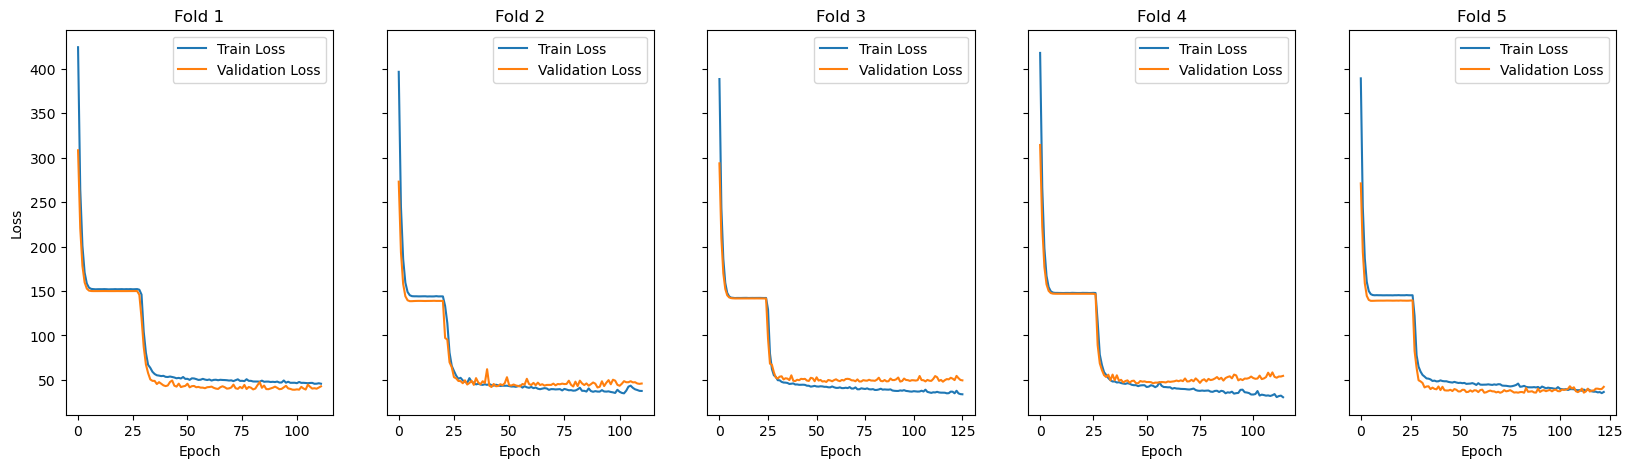

In [20]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config

epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, LSTM, model_type, model_params_keys, num_epochs = num_epochs, seed=seed, X=X, y=y, normalize_flags=NORMALIZE_FLAGS)

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()